In [1]:
library(ggplot2)
library(reshape2)
library(RColorBrewer)
library(igraph)
library(dplyr)
library(ggpubr)


Adjuntando el paquete: 'igraph'


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union



Adjuntando el paquete: 'dplyr'


The following objects are masked from 'package:igraph':

    as_data_frame, groups, union


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'ggpubr' was built under R version 4.5.1"


In [3]:
# funcs
make_grid <- function(L, F, q) {
  my_grid <- array(sample(1:q, L*L*F, replace=TRUE), dim=c(L, L, F))
  return(my_grid)
}

# calc overlap
do_overlap <- function(agent1, agent2) {
  sum(agent1 == agent2)
}

# get peeps next door
get_hood <- function(i, j, L) {
  peeps <- list(
    c((i - 2 + L) %% L + 1, j),
    c(i, (j %% L) + 1),
    c((i %% L) + 1, j),
    c(i, (j - 2 + L) %% L + 1)
  )
  return(peeps)
}

# run model
run_axelrod <- function(my_grid, max_steps, store_every = NULL) {
  L <- dim(my_grid)[1]
  F <- dim(my_grid)[3]
  pics <- list()

  step <- 0
  repeat {
    step <- step + 1
    did_change <- FALSE

    spots <- sample(L*L)

    for (k in spots) {
      i <- (k - 1) %% L + 1
      j <- floor((k - 1) / L) + 1

      peeps <- get_hood(i, j, L)

      n_idx <- sample(1:4, 1)
      ni <- peeps[[n_idx]][1]
      nj <- peeps[[n_idx]][2]

      agent_me <- my_grid[i,j,]
      agent_them <- my_grid[ni,nj,]

      how_much_same <- do_overlap(agent_me, agent_them)

      if (how_much_same > 0 && how_much_same < F) {
        chance <- how_much_same / F
        if (runif(1) < chance) {
          diff_stuff <- which(agent_me != agent_them)
          if (length(diff_stuff) > 0) {
            pick_one <- sample(diff_stuff, 1)
            my_grid[i,j,pick_one] <- agent_them[pick_one]
            did_change <- TRUE
          }
        }
      }
    }

    if (!is.null(store_every) && (step %% store_every == 0 || step == 1 || !did_change)) {
      culture_stuff <- apply(my_grid, c(1,2), function(x) paste(x, collapse=""))
      pics[[length(pics)+1]] <- list(sweep = step, culture_matrix = culture_stuff)
    }

    if (!did_change || step >= max_steps) {
      break
    }
  }

  return(list(
    snapshots = pics,
    final_grid = my_grid,
    sweeps_taken = step
  ))
}

# plot grid
show_grid <- function(culture_matrix, L, title_text = "") {
  df <- data.frame(
    X = rep(1:L, each = L),
    Y = rep(1:L, times = L),
    Culture = as.vector(culture_matrix)
  )

  unique_cultures <- unique(df$Culture)
  num_unique_cultures <- length(unique_cultures)

  if (num_unique_cultures > 12) {
    colors_palette <- colorRampPalette(RColorBrewer::brewer.pal(12, "Set3"))(num_unique_cultures)
  } else {
    colors_palette <- RColorBrewer::brewer.pal(max(3, num_unique_cultures), "Set3")[1:num_unique_cultures]
  }

  names(colors_palette) <- unique_cultures

  ggplot(df, aes(x=X, y=Y, fill=Culture)) +
    geom_tile(color="white") +
    scale_fill_manual(values=colors_palette) +
    theme_void() +
    theme(legend.position="none", plot.title = element_text(hjust = 0.5)) +
    coord_fixed() +
    ggtitle(title_text)
}

# count regions
count_regions <- function(grid) {
  L <- dim(grid)[1]

  culture_id <- apply(grid, c(1,2), function(x) paste(x, collapse=""))

  g <- make_empty_graph(n = L*L, directed = FALSE)

  cell_id <- function(i, j) {(i - 1) * L + j}

  for (i in 1:L) {
    for (j in 1:L) {
      this_id <- cell_id(i, j)

      nj_right <- (j %% L) + 1
      if (culture_id[i, j] == culture_id[i, nj_right]) {
        g <- add_edges(g, c(this_id, cell_id(i, nj_right)))
      }

      ni_down <- (i %% L) + 1
      if (culture_id[i, j] == culture_id[ni_down, j]) {
        g <- add_edges(g, c(this_id, cell_id(ni_down, j)))
      }
    }
  }

  stuff <- components(g)

  return(list(no = stuff$no, csize = stuff$csize))
}


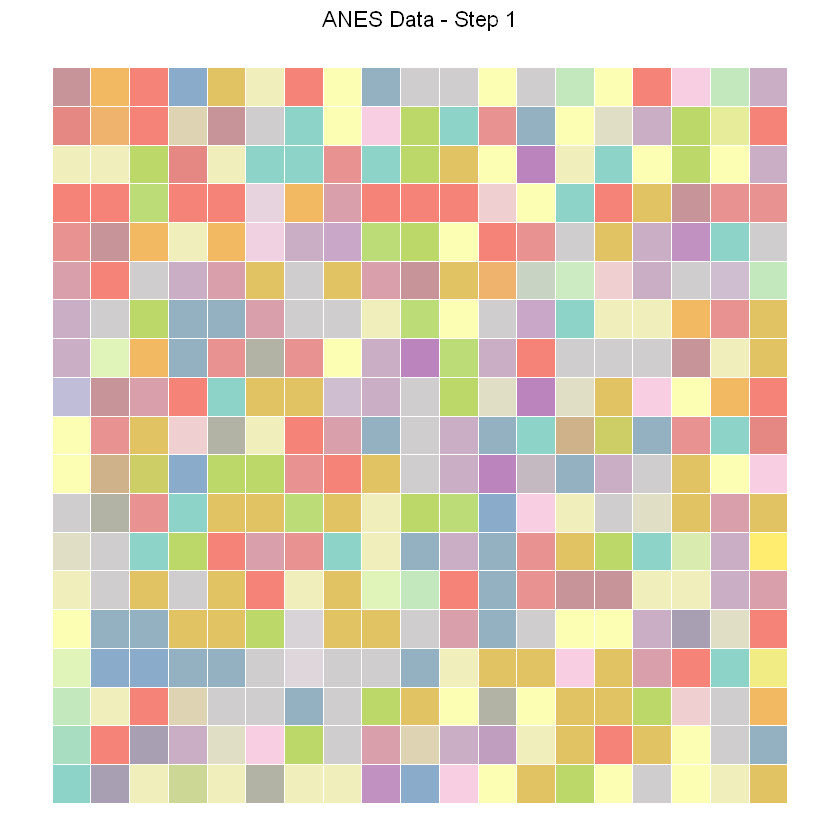

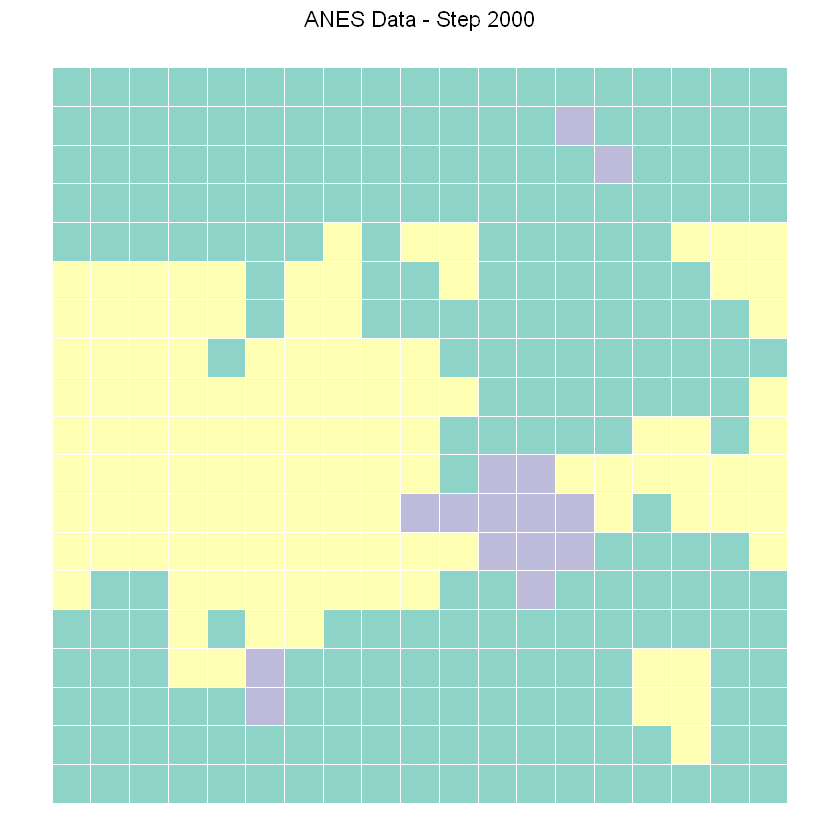

file saved to Axelrod_ANES_All_Snapshots.pdf



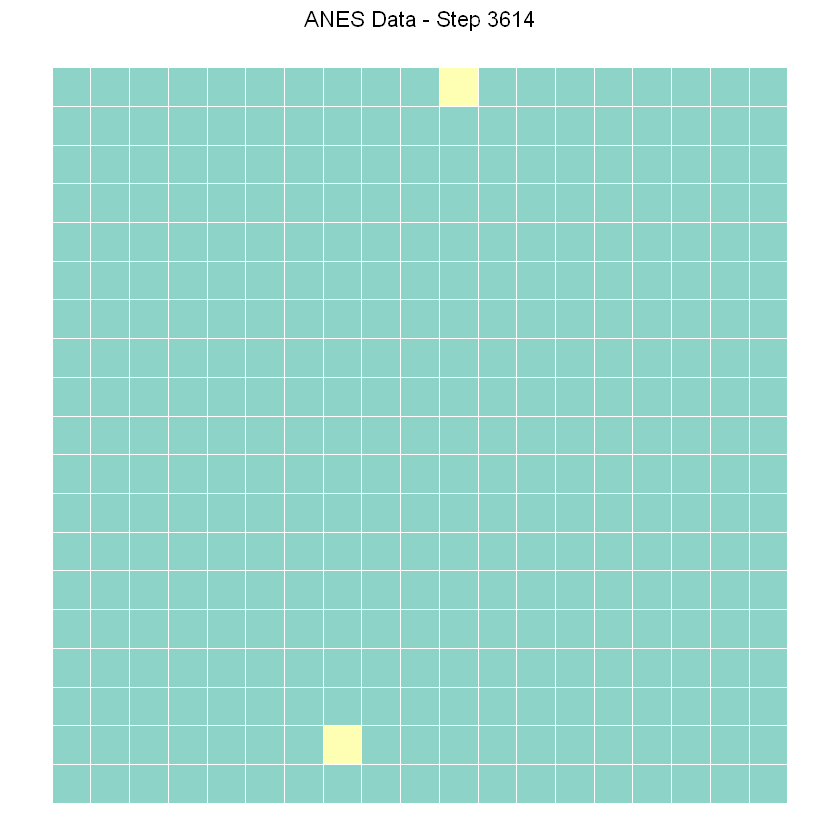

In [5]:
# ANES stuff

anes_data_raw <- read.csv("anes_timeseries_2024_csv_20250430.csv")

my_cols <- c("V241003", "V241025", "V241031", "V241043")
anes_data_some <- anes_data_raw %>%
  select(all_of(my_cols))

bad_codes <- c(-1, -8, -9)

anes_data_ok <- anes_data_some %>%
  mutate(across(everything(), ~ifelse(. %in% bad_codes, NA, .))) %>%
  na.omit()

anes_data_ready <- anes_data_ok

max_q_vals <- c()

for (col_name in my_cols) {
  uniq_vals <- sort(unique(anes_data_ok[[col_name]]))
  mapper <- setNames(1:length(uniq_vals), uniq_vals)
  anes_data_ready[[col_name]] <- mapper[as.character(anes_data_ok[[col_name]])]
  max_q_vals <- c(max_q_vals, max(mapper))
}

F_count <- length(my_cols)
Big_Q <- max(max_q_vals)

agent_num <- nrow(anes_data_ready)
L_anes <- floor(sqrt(agent_num))
agents_for_grid <- L_anes * L_anes

if (agents_for_grid < agent_num) {
  anes_data_ready <- anes_data_ready[1:agents_for_grid, ]
} else if (agents_for_grid > agent_num) {
  stop("not enough agents for grid")
}

start_grid_anes <- array(
  as.matrix(anes_data_ready),
  dim = c(L_anes, L_anes, F_count)
)

big_sweeps <- 10000
save_interval <- 2000

result_anes <- run_axelrod(start_grid_anes, big_sweeps, save_interval)

all_plots <- list()

for (snap_data in result_anes$snapshots) {
  step_num <- snap_data$sweep
  culture_mat <- snap_data$culture_matrix

  current_plot <- show_grid(culture_mat, L_anes, title_text = paste("ANES Data - Step", step_num))

  print(current_plot)

  plot_name <- paste0("Snapshot_Step_", step_num)
  all_plots[[plot_name]] <- current_plot
}

ggexport(plotlist = all_plots, filename = "Axelrod_ANES_All_Snapshots.pdf", width = 8, height = 8)

final_culture_id_anes <- apply(result_anes$final_grid, c(1,2), function(x) paste(x, collapse=""))
final_plot_anes <- show_grid(final_culture_id_anes, L_anes, title_text = paste("ANES Data - Final Grid at Step", result_anes$sweeps_taken))

final_region_stuff <- count_regions(result_anes$final_grid)

In [7]:
# F and q analysis

set.seed(42)
L_Fq <- 10
big_sweeps_Fq <- 100000
runs_Fq <- 5

F_vals <- c(5, 10, 15)
q_vals <- c(5, 10, 15)

results_table <- matrix(NA, nrow=length(F_vals), ncol=length(q_vals),
                        dimnames = list(paste0("F=", F_vals),
                                        paste0("q=", q_vals)))

for (f_v in F_vals) {
  for (q_v in q_vals) {
    region_counts <- numeric(runs_Fq)
    for (r in 1:runs_Fq) {
      sim_Fq <- run_axelrod(make_grid(L = L_Fq, F = f_v, q = q_v), max_steps = big_sweeps_Fq)
      region_counts[r] <- count_regions(sim_Fq$final_grid)$no
    }
    avg_regions <- mean(region_counts)
    results_table[paste0("F=",f_v), paste0("q=",q_v)] <- avg_regions
  }
}

In [9]:
print(results_table)

     q=5 q=10 q=15
F=5  1.2  2.4  5.0
F=10 1.2  1.4  1.6
F=15 1.2  1.6  1.8


In [ ]:
# Phase Transition stuff

set.seed(42)
L_pt <- 20
F_pt <- 10
big_sweeps_pt <- 50000
runs_pt <- 10

q_vals_pt <- seq(1, 120, by = 5)

smax_avg_relative <- numeric(length(q_vals_pt))
N_total <- L_pt * L_pt

for (i in seq_along(q_vals_pt)) {
  q_now <- q_vals_pt[i]
  smax_values_run <- numeric(runs_pt)

  for (run in 1:runs_pt) {
    sim_pt <- run_axelrod(make_grid(L = L_pt, F = F_pt, q = q_now), max_steps = big_sweeps_pt)

    region_data <- count_regions(sim_pt$final_grid)

    if (length(region_data$csize) > 0) {
      smax <- max(region_data$csize)
    } else {
      smax <- 0
    }

    smax_values_run[run] <- smax / N_total
  }
  smax_avg_relative[i] <- mean(smax_values_run)
}

plot_data_pt <- data.frame(
  q = q_vals_pt,
  Smax_Relative_Avg = smax_avg_relative
)

phase_plot <- ggplot(plot_data_pt, aes(x = q, y = Smax_Relative_Avg)) +
  geom_line(color = "darkgreen", size = 1) +
  geom_point(color = "darkblue", size = 3, pch = 19) +
  labs(
    title = paste0("Phase Transition: <Smax>/N vs q (L=", L_pt, ", F=", F_pt, ")"),
    x = "Number of Traits per Feature (q)",
    y = expression(paste("Average Relative Size of Biggest Region (", S[max], "/N)"))
  ) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5)) +
  ylim(0, 1)

# print(phase_plot)
ggsave("plot_phase_transition_2.pdf", plot = phase_plot, width = 8, height = 6)